In [1]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller, kpss, acf, grangercausalitytests
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf,month_plot,quarter_plot
import statsmodels.tsa.api as smt
import statsmodels.api as sm
from scipy import signal
from scipy import stats 
import matplotlib.pyplot as plt
import seaborn as sns 
from sklearn.metrics import mean_absolute_error
from statsmodels.tsa.seasonal import seasonal_decompose
from dateutil.parser import parse


%matplotlib inline 
sns.set_style("whitegrid")
plt.rc('xtick', labelsize=15) 
plt.rc('ytick', labelsize=15) 

# Lendo o dataset de treino


In [2]:
data = pd.read_csv('../../data/ElectricDemandForecasting-DL-master_data_hourly_20140102_20191101_train.csv')


In [3]:
def plot_df(df, x, y, title="", xlabel='Date', ylabel='Value', dpi=100):
    plt.figure(figsize=(20,5), dpi=dpi)
    plt.plot(x, y, color='tab:red')
    plt.gca().set(title=title, xlabel=xlabel, ylabel=ylabel)
    plt.show()

def mean_absolute_percentage_error(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

def plot_moving_average(series, window, plot_intervals=False, scale=1.96):

    rolling_mean = series.rolling(window=window).mean()
    
    plt.figure(figsize=(17,8))
    plt.title('Moving average\n window size = {}'.format(window))
    plt.plot(rolling_mean, 'r', label='Rolling mean trend')
    
    #Plot confidence intervals for smoothed values
    if plot_intervals:
        mae = mean_absolute_error(series[window:], rolling_mean[window:])
        deviation = np.std(series[window:] - rolling_mean[window:])
        lower_bound = rolling_mean - (mae + scale * deviation)
        upper_bound = rolling_mean + (mae + scale * deviation)
        plt.plot(upper_bound, 'm--', label='Upper bound / Lower bound')
        plt.plot(lower_bound, 'm--')
            
    plt.plot(series[window:], label='Actual values')
    plt.legend(loc='best')
    plt.grid(True)

def tsplot(y, lags=None, figsize=(12, 7), syle='bmh'):
    
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
        
    with plt.style.context(style='bmh'):
        fig = plt.figure(figsize=figsize)
        layout = (2,2)
        ts_ax = plt.subplot2grid(layout, (0,0), colspan=2)
        acf_ax = plt.subplot2grid(layout, (1,0))
        pacf_ax = plt.subplot2grid(layout, (1,1))
        
        y.plot(ax=ts_ax)
        p_value = adfuller(y, autolag='AIC')[1]
        ts_ax.set_title('Time Series Analysis Plots\n Dickey-Fuller: p={0:.5f}'.format(p_value))
        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax)
        plt.tight_layout()

In [4]:
data['datetime']=pd.to_datetime(data['datetime'], utc=True)

In [5]:
data['ano']=data['datetime'].dt.year
data['mes']=data['datetime'].dt.month
data['hora']=data['datetime'].dt.hour
data['min']=data['datetime'].dt.minute

In [6]:
data.head()

,value,percentage,datetime,ano,mes,hora,min
0,24256,0.340316,2014-01-01 23:00:00+00:00,2014,1,23,0
1,24260,0.343019,2014-01-01 23:10:00+00:00,2014,1,23,10
2,23689,0.340178,2014-01-01 23:20:00+00:00,2014,1,23,20
3,23349,0.339301,2014-01-01 23:30:00+00:00,2014,1,23,30
4,22896,0.337122,2014-01-01 23:40:00+00:00,2014,1,23,40


In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 245376 entries, 0 to 245375
Data columns (total 7 columns):
value         245376 non-null int64
percentage    245376 non-null float64
datetime      245376 non-null datetime64[ns, UTC]
ano           245376 non-null int64
mes           245376 non-null int64
hora          245376 non-null int64
min           245376 non-null int64
dtypes: datetime64[ns, UTC](1), float64(1), int64(5)
memory usage: 13.1 MB


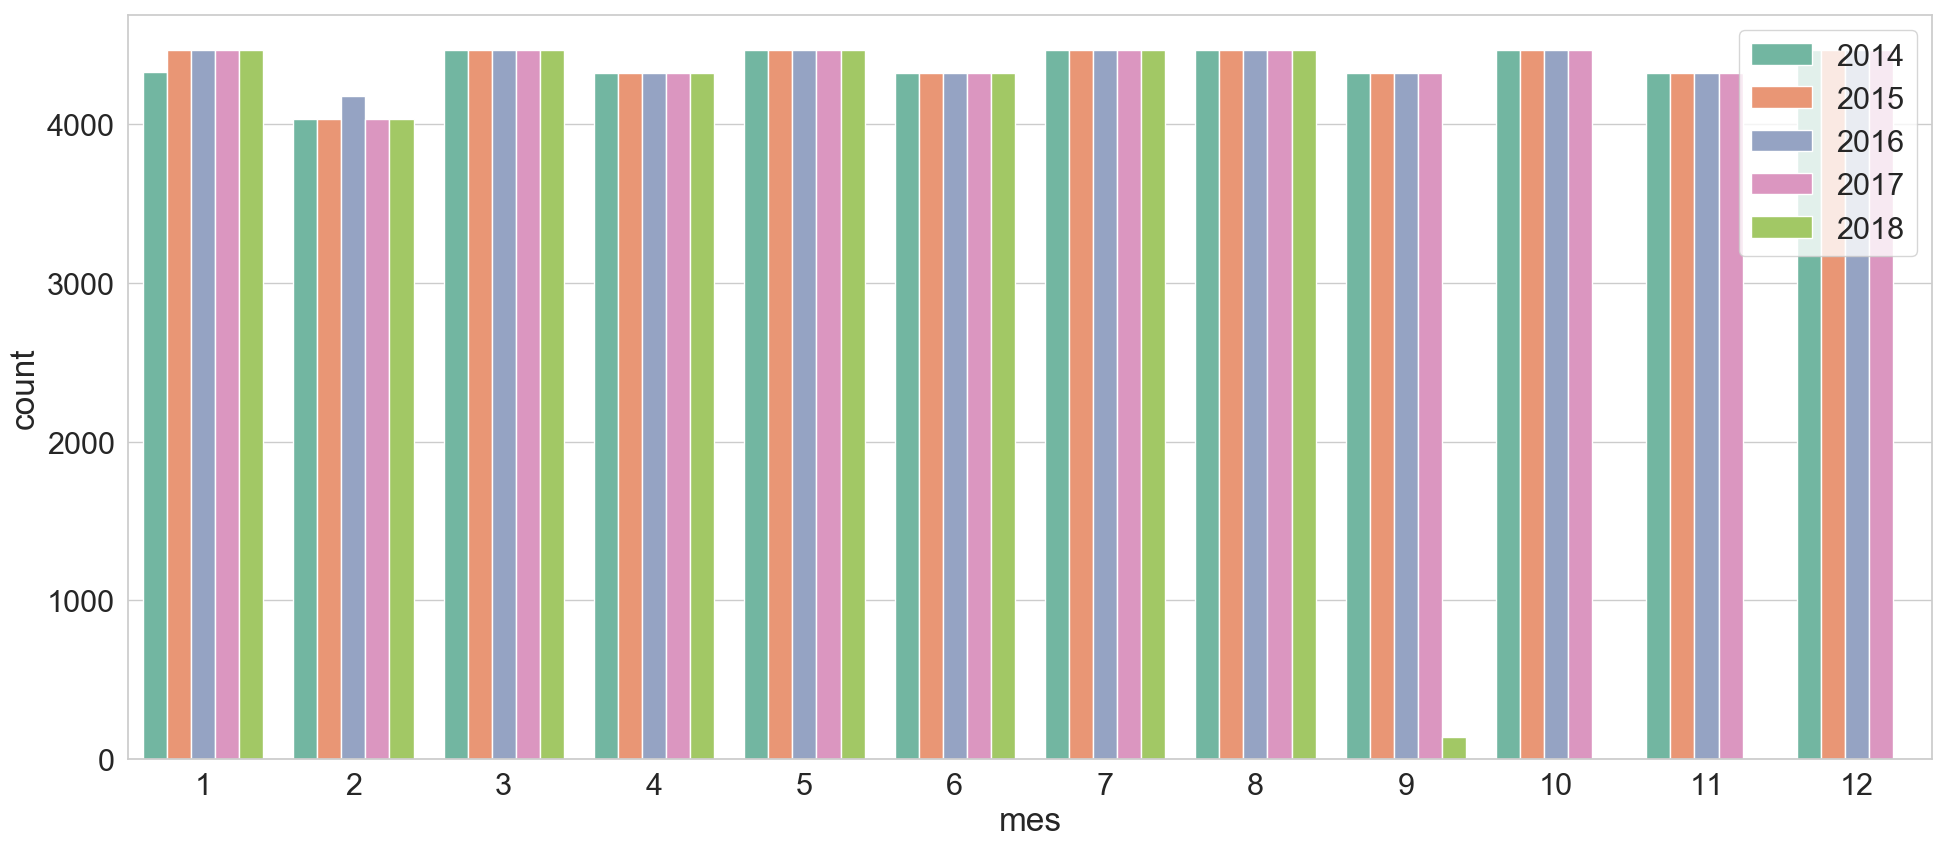

In [8]:
## Histograma de quantidade de dados por meses do ano

plt.figure(figsize=(20,9), dpi=100)

sns.set_context('notebook', font_scale = 2)

sns.countplot(x='mes', data = data, hue = 'ano', palette='Set2')

plt.legend(loc=0)

plt.tight_layout()

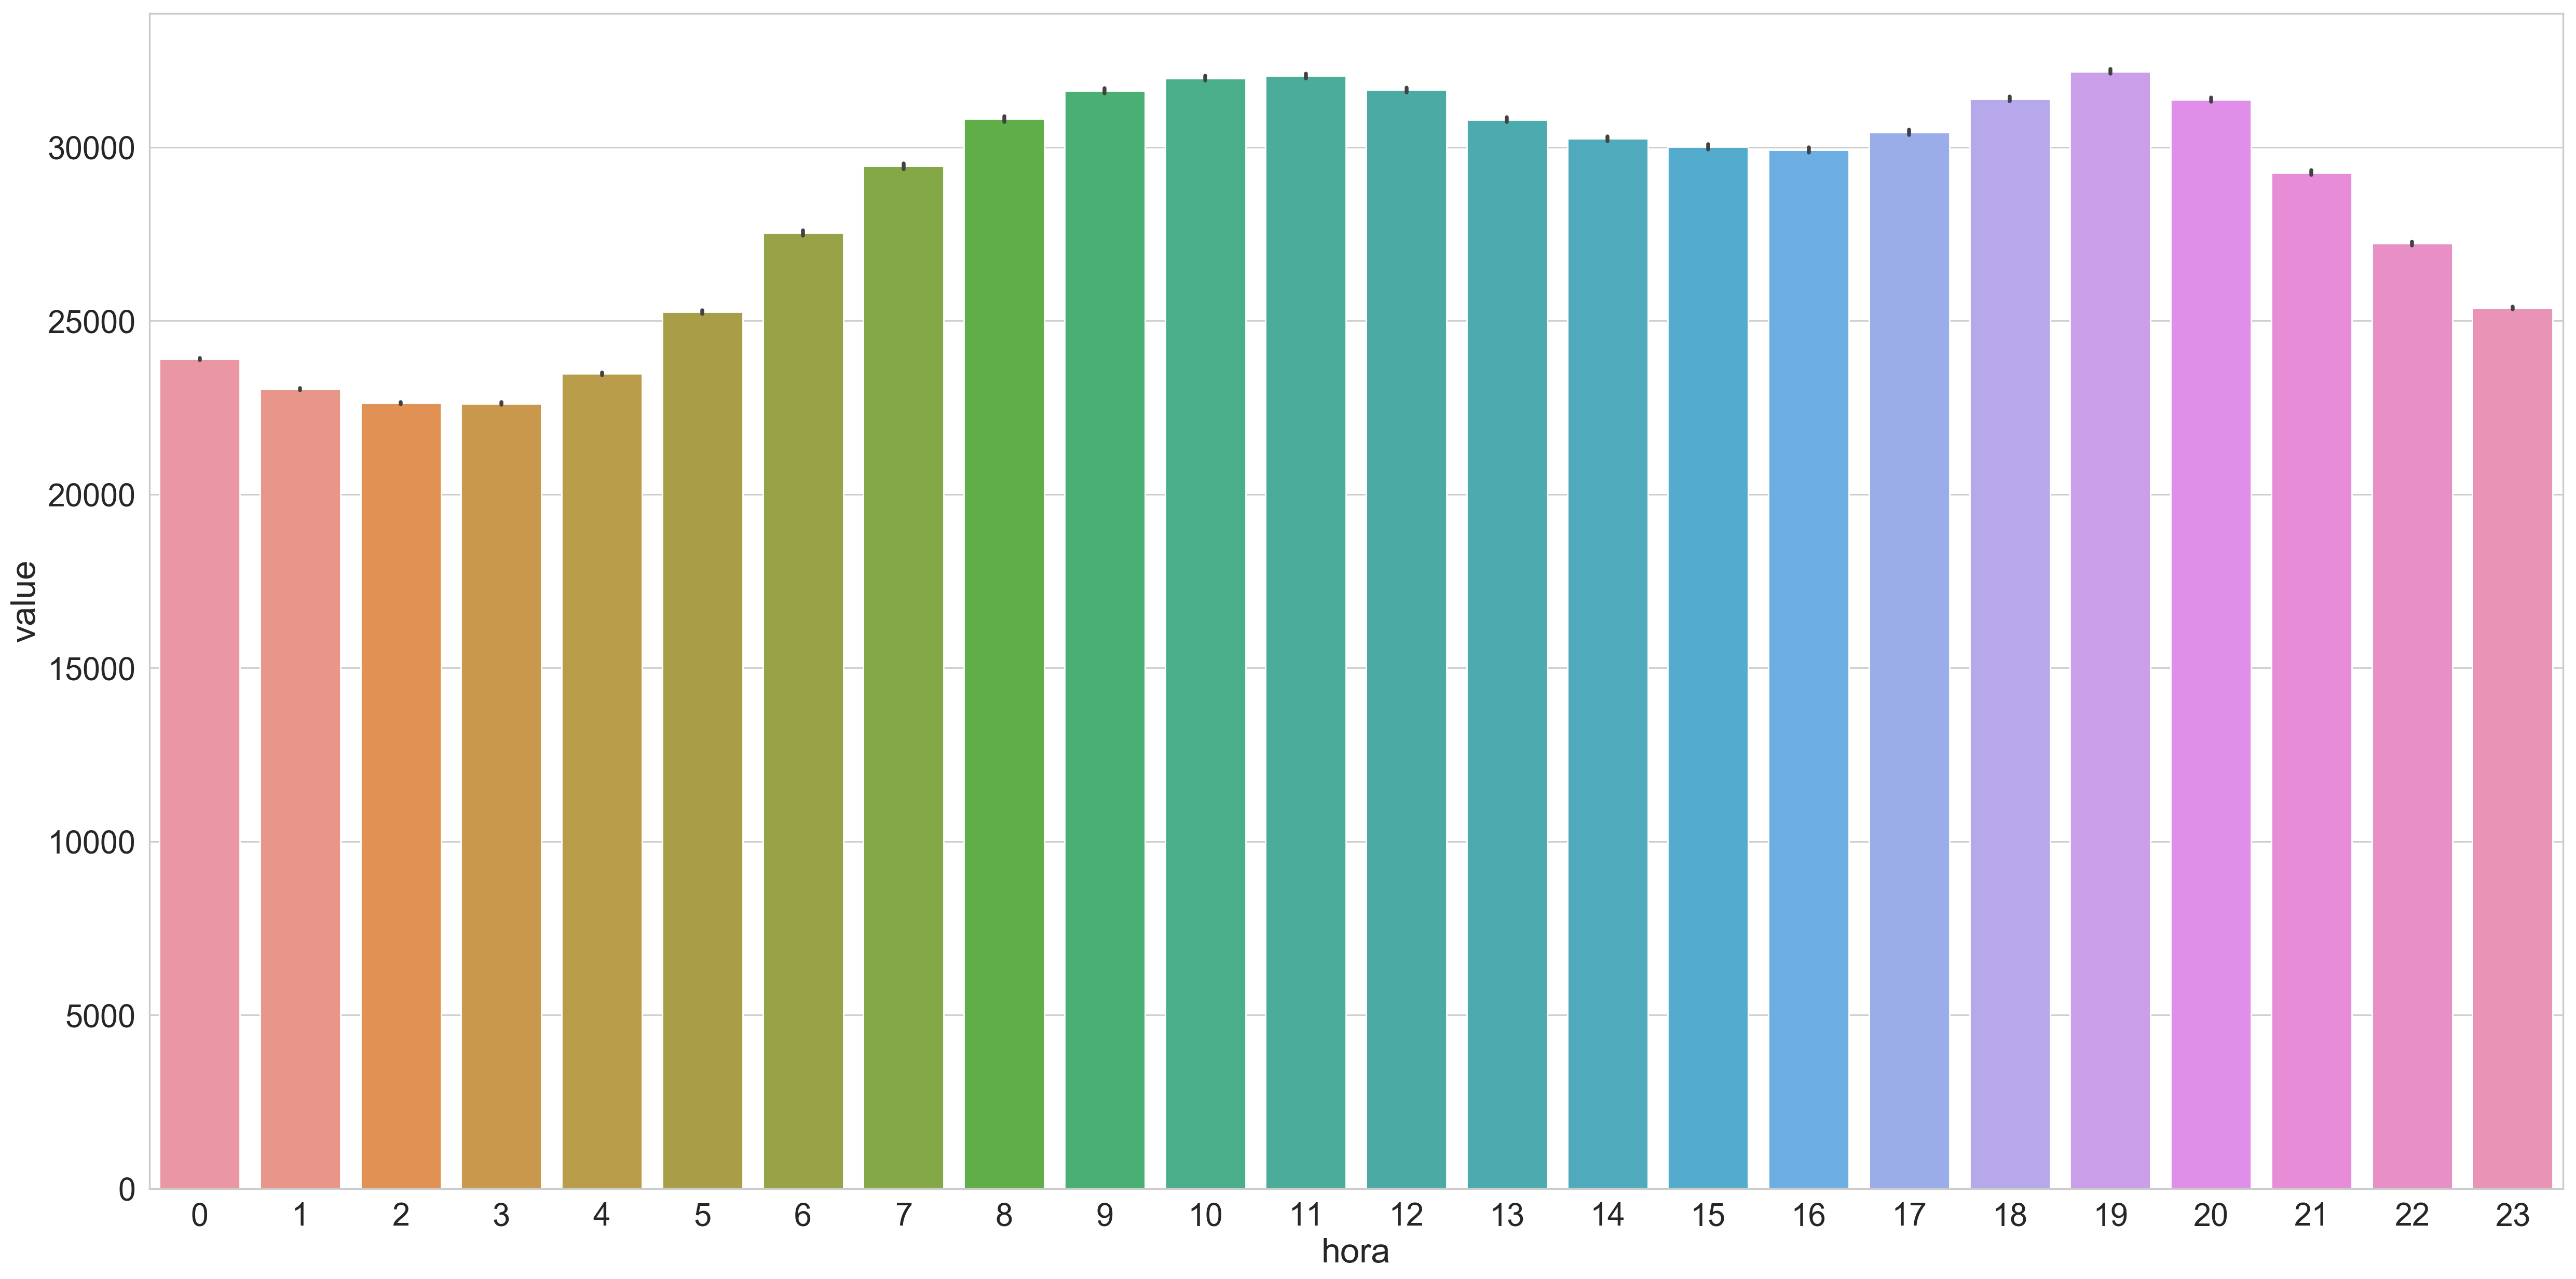

In [9]:
## Plot dos valores por hora no ano de 2014

plt.figure(figsize=(30,15), dpi=200)

sns.barplot(x='hora', y='value',data=data)

In [10]:
######################### PLOTS HORÁRIOS, DIÁRIOS, MENSAIS E SEMANAIS COM SOMATÓRIO E MÉDIA ###################################

hourly_s = data.set_index('datetime').resample('H').sum()
daily_s = data.set_index('datetime').resample('D').sum()
weekly_s = data.set_index('datetime').resample('W').sum()
monthly_s = data.set_index('datetime').resample('M').sum()

hourly_m = data.set_index('datetime').resample('H').mean()
daily_m = data.set_index('datetime').resample('D').mean()
weekly_m = data.set_index('datetime').resample('W').mean()
monthly_m = data.set_index('datetime').resample('M').mean()


C:\Users\Not\Anaconda2\lib\site-packages\pandas\plotting\_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


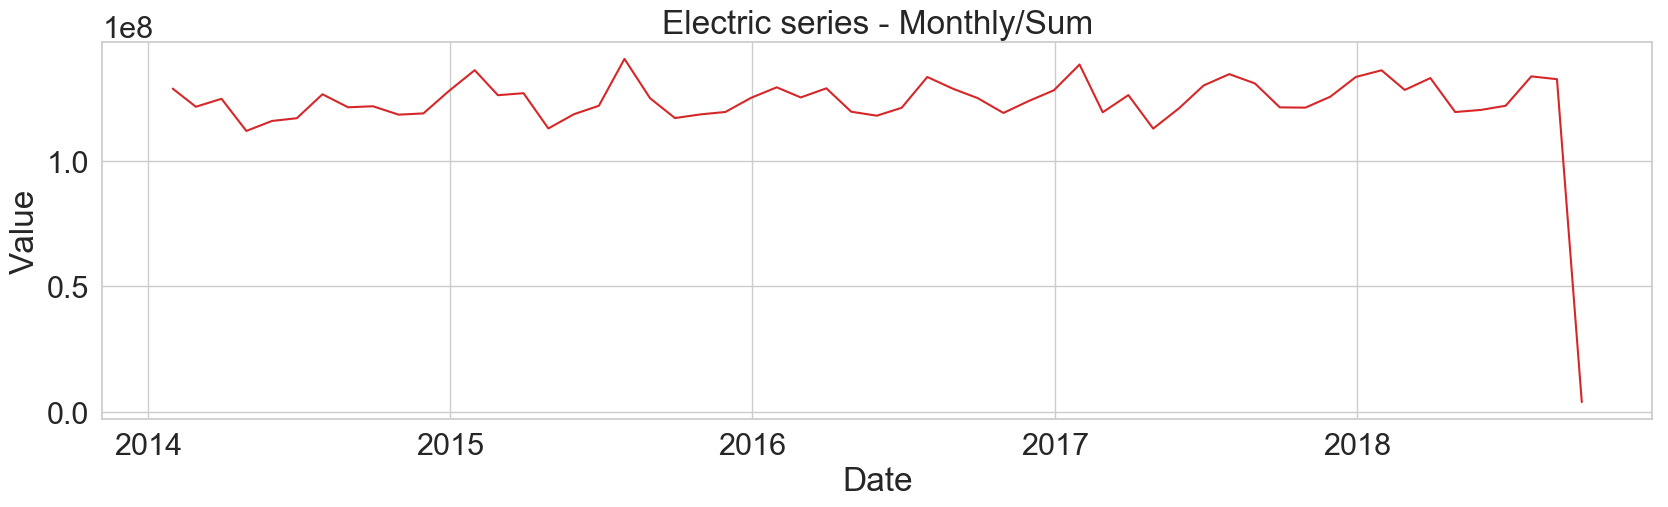

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 57 entries, 2014-01-31 00:00:00+00:00 to 2018-09-30 00:00:00+00:00
Freq: M
Data columns (total 6 columns):
value         57 non-null int64
percentage    57 non-null float64
ano           57 non-null int64
mes           57 non-null int64
hora          57 non-null int64
min           57 non-null int64
dtypes: float64(1), int64(5)
memory usage: 3.1 KB


In [11]:
plot_df(monthly_s, x=monthly_s.index, y=monthly_s.value, title="Electric series - Monthly/Sum")
monthly_s.info()

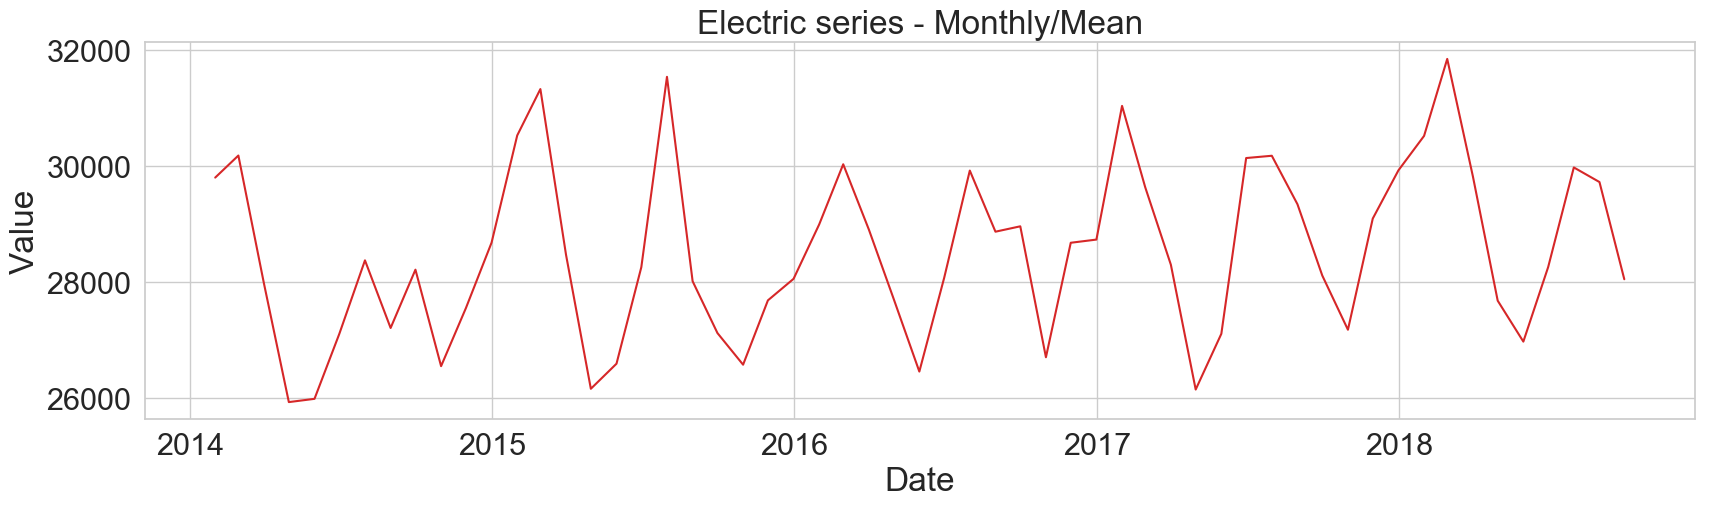

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 57 entries, 2014-01-31 00:00:00+00:00 to 2018-09-30 00:00:00+00:00
Freq: M
Data columns (total 6 columns):
value         57 non-null float64
percentage    57 non-null float64
ano           57 non-null float64
mes           57 non-null float64
hora          57 non-null float64
min           57 non-null float64
dtypes: float64(6)
memory usage: 3.1 KB


In [12]:
plot_df(monthly_m, x=monthly_m.index, y=monthly_m.value, title="Electric series - Monthly/Mean")
monthly_m.info()

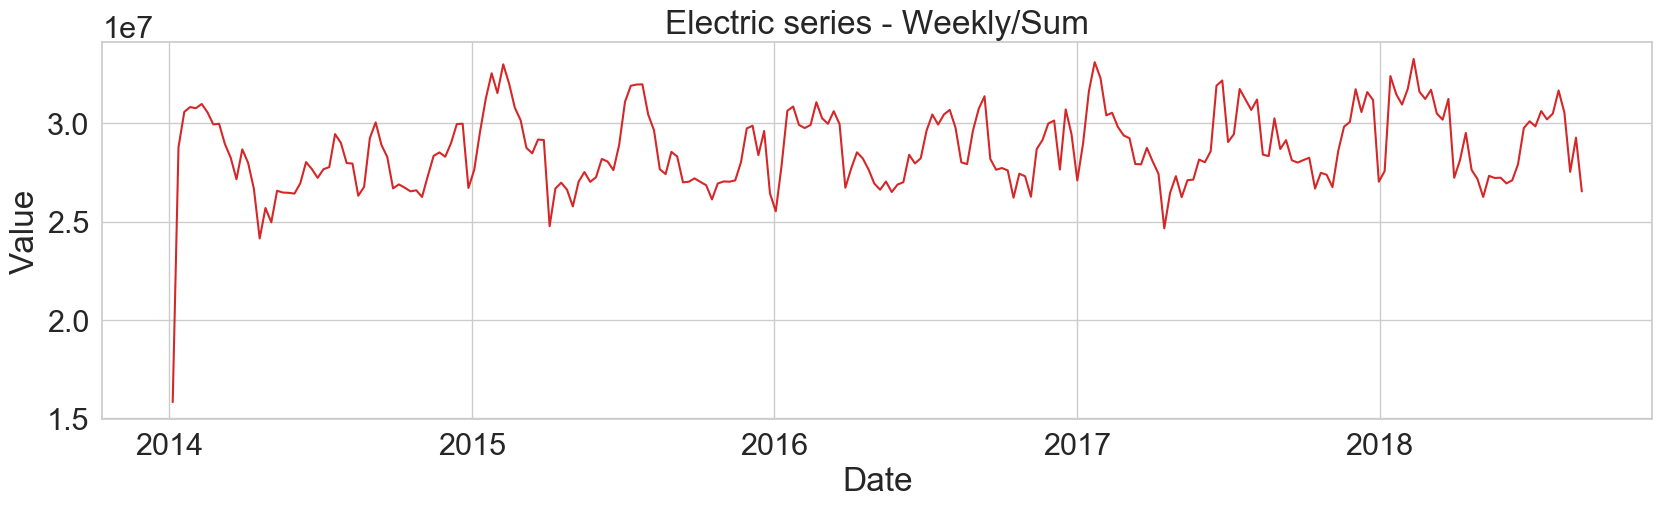

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 244 entries, 2014-01-05 00:00:00+00:00 to 2018-09-02 00:00:00+00:00
Freq: W-SUN
Data columns (total 6 columns):
value         244 non-null int64
percentage    244 non-null float64
ano           244 non-null int64
mes           244 non-null int64
hora          244 non-null int64
min           244 non-null int64
dtypes: float64(1), int64(5)
memory usage: 13.3 KB


In [13]:
plot_df(weekly_s, x=weekly_s.index, y=weekly_s.value, title="Electric series - Weekly/Sum")
weekly_s.info()

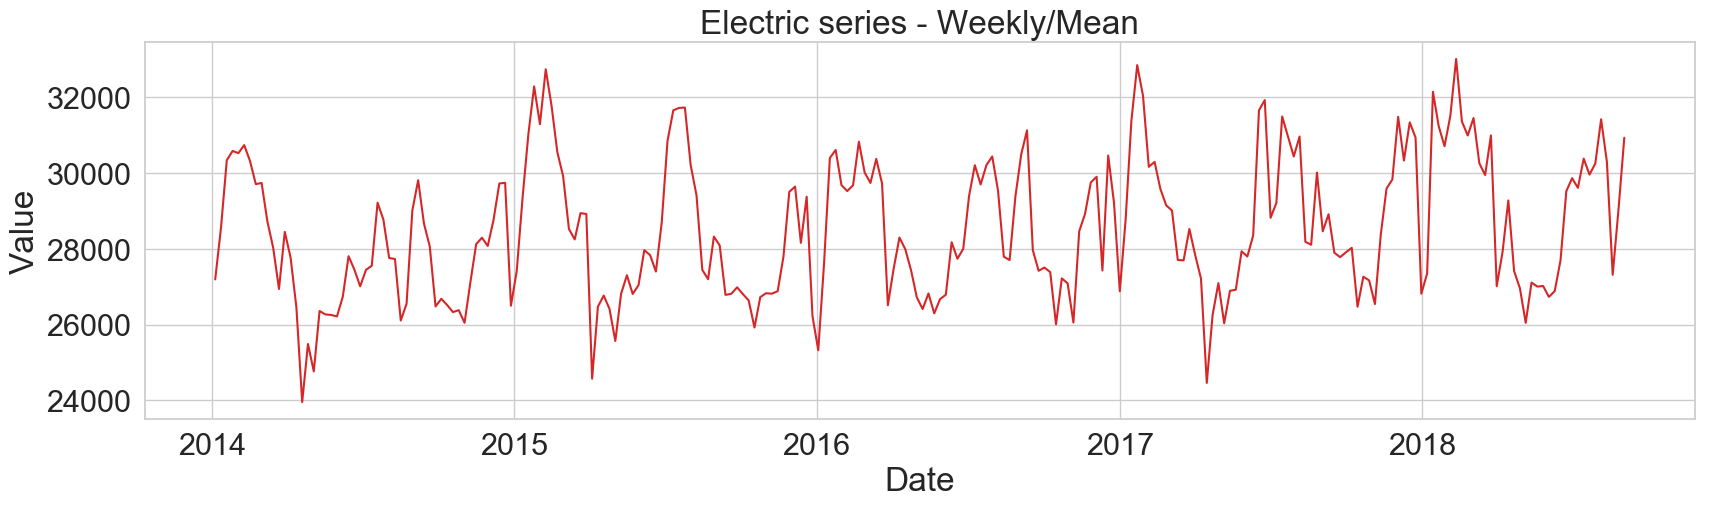

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 244 entries, 2014-01-05 00:00:00+00:00 to 2018-09-02 00:00:00+00:00
Freq: W-SUN
Data columns (total 6 columns):
value         244 non-null float64
percentage    244 non-null float64
ano           244 non-null float64
mes           244 non-null float64
hora          244 non-null float64
min           244 non-null float64
dtypes: float64(6)
memory usage: 13.3 KB


In [14]:
plot_df(weekly_m, x=weekly_m.index, y=weekly_m.value, title="Electric series - Weekly/Mean")
weekly_m.info()

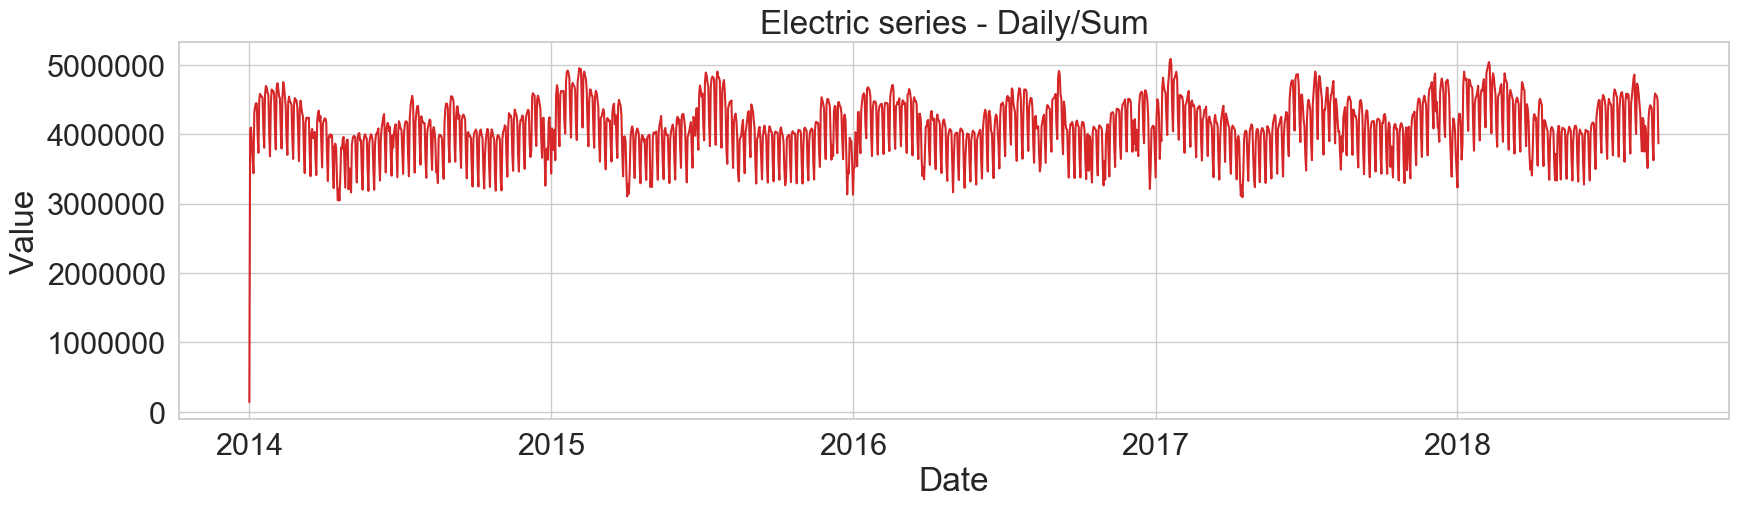

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1705 entries, 2014-01-01 00:00:00+00:00 to 2018-09-01 00:00:00+00:00
Freq: D
Data columns (total 6 columns):
value         1705 non-null int64
percentage    1705 non-null float64
ano           1705 non-null int64
mes           1705 non-null int64
hora          1705 non-null int64
min           1705 non-null int64
dtypes: float64(1), int64(5)
memory usage: 93.2 KB


In [15]:
plot_df(daily_s, x=daily_s.index, y=daily_s.value, title="Electric series - Daily/Sum")
daily_s.info()

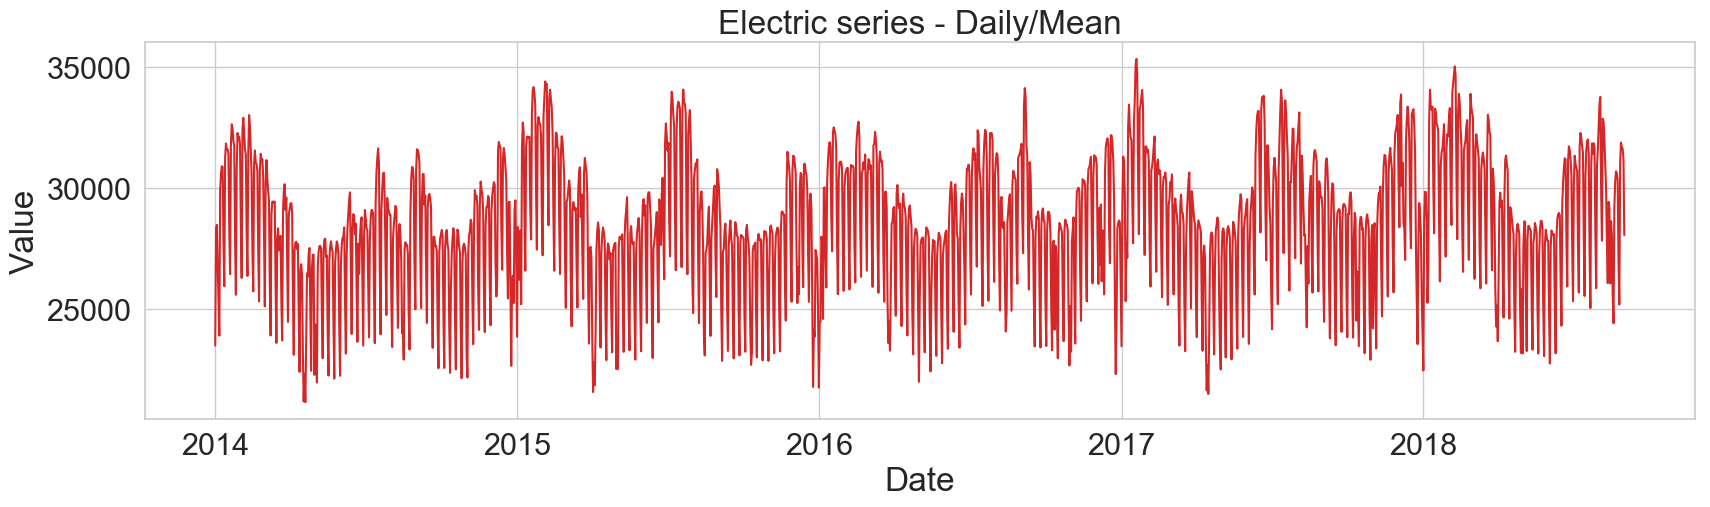

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1705 entries, 2014-01-01 00:00:00+00:00 to 2018-09-01 00:00:00+00:00
Freq: D
Data columns (total 6 columns):
value         1705 non-null float64
percentage    1705 non-null float64
ano           1705 non-null float64
mes           1705 non-null float64
hora          1705 non-null float64
min           1705 non-null float64
dtypes: float64(6)
memory usage: 93.2 KB


In [16]:
plot_df(daily_m, x=daily_m.index, y=daily_m.value, title="Electric series - Daily/Mean")
daily_m.info()

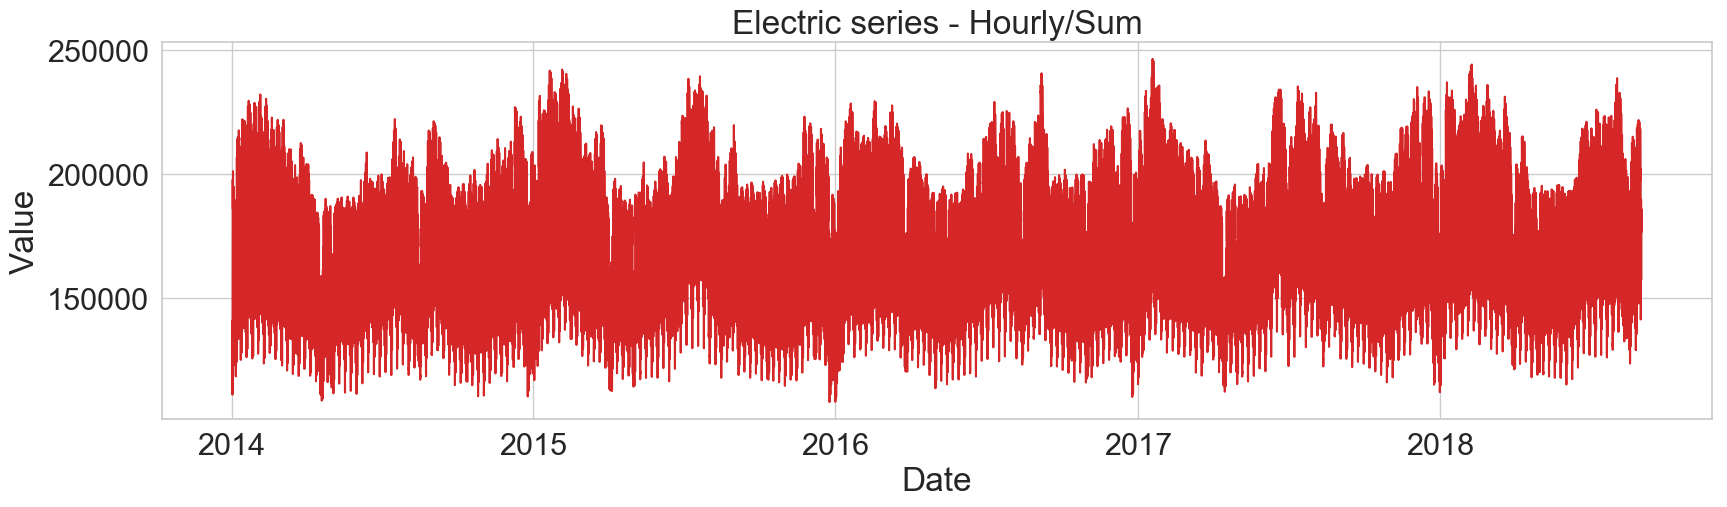

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1705 entries, 2014-01-01 00:00:00+00:00 to 2018-09-01 00:00:00+00:00
Freq: D
Data columns (total 6 columns):
value         1705 non-null int64
percentage    1705 non-null float64
ano           1705 non-null int64
mes           1705 non-null int64
hora          1705 non-null int64
min           1705 non-null int64
dtypes: float64(1), int64(5)
memory usage: 93.2 KB


In [17]:
plot_df(hourly_s, x=hourly_s.index, y=hourly_s.value, title="Electric series - Hourly/Sum")
daily_s.info()

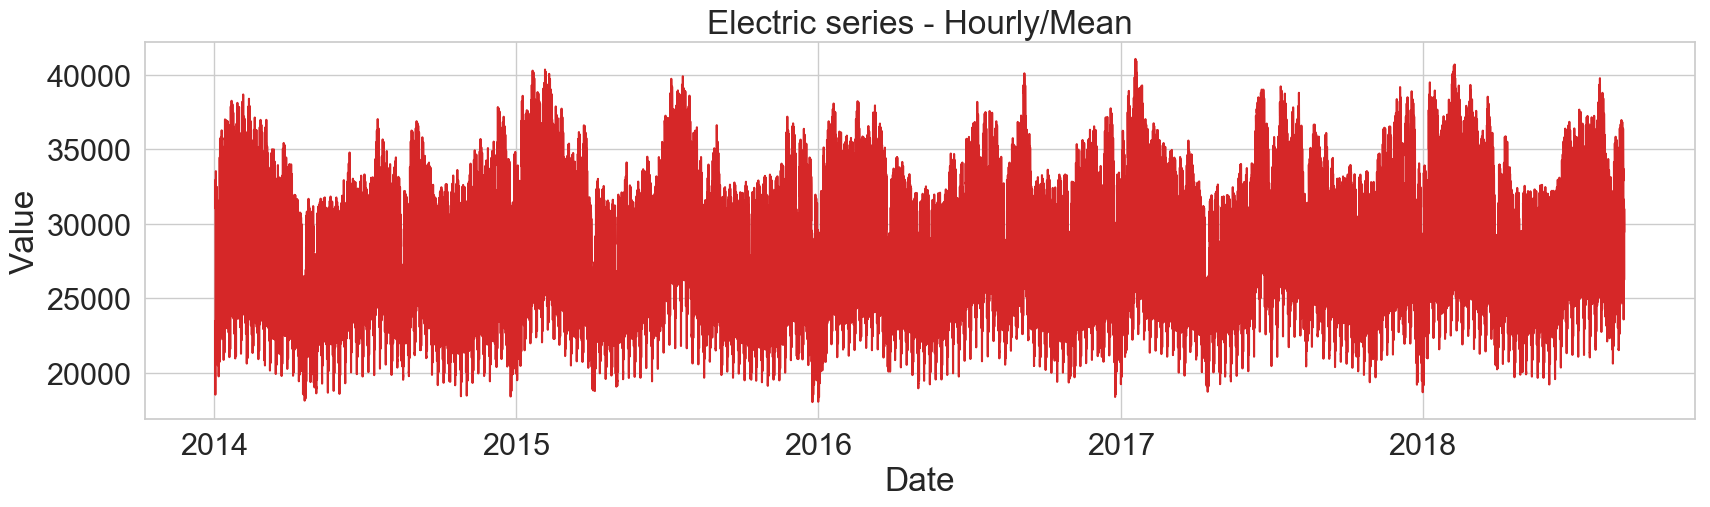

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 40896 entries, 2014-01-01 23:00:00+00:00 to 2018-09-01 22:00:00+00:00
Freq: H
Data columns (total 6 columns):
value         40896 non-null float64
percentage    40896 non-null float64
ano           40896 non-null float64
mes           40896 non-null float64
hora          40896 non-null float64
min           40896 non-null float64
dtypes: float64(6)
memory usage: 2.2 MB


In [18]:
plot_df(hourly_m, x=hourly_m.index, y=hourly_m.value, title="Electric series - Hourly/Mean")
hourly_m.info()

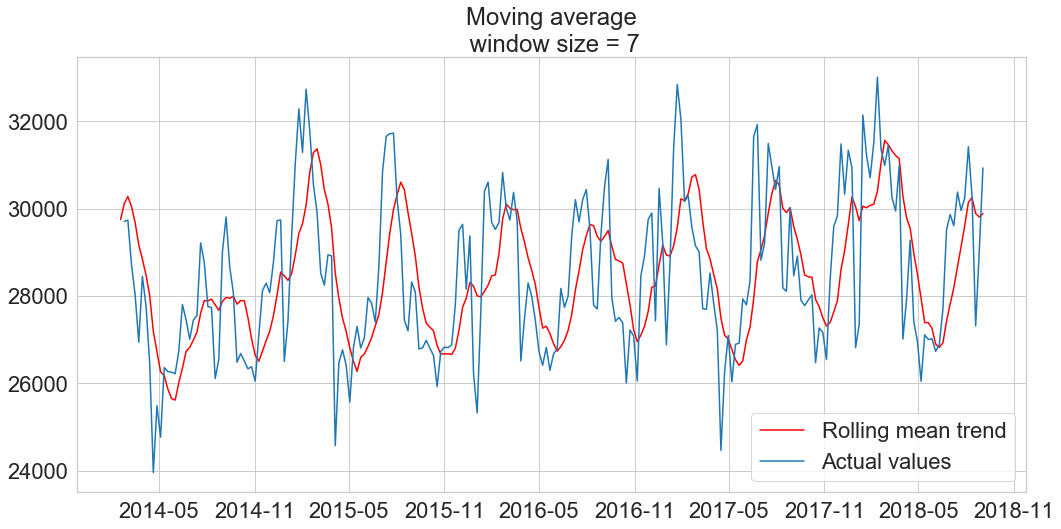

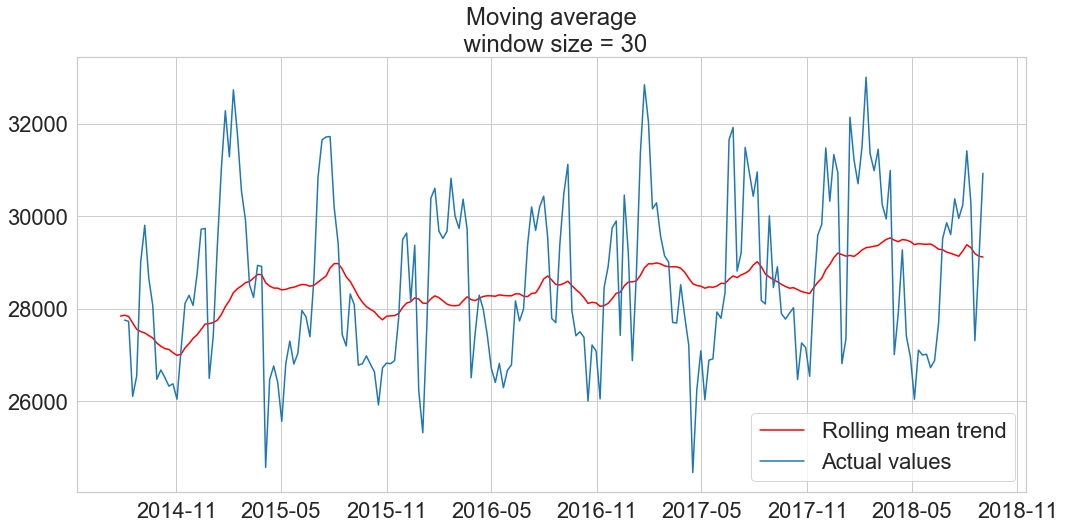

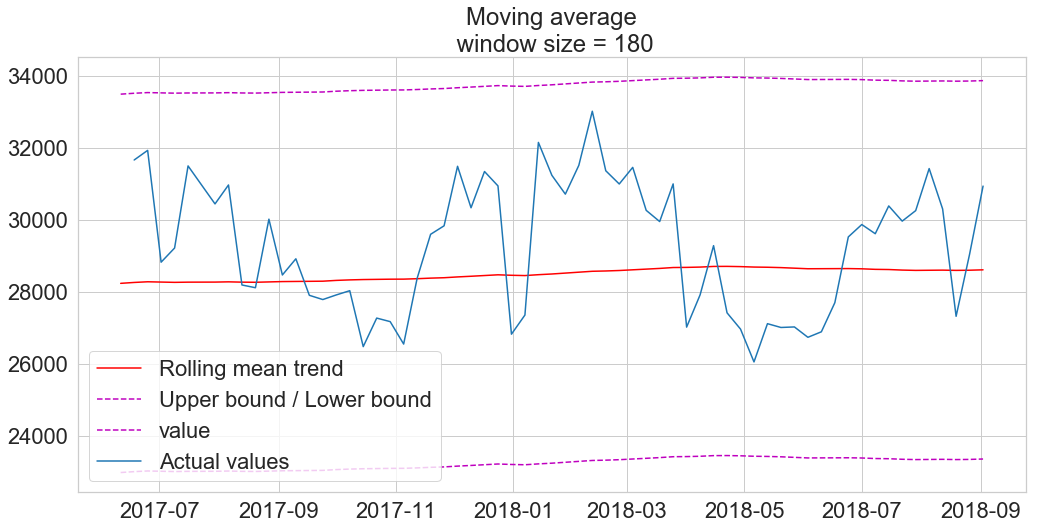

In [19]:
plot_moving_average(weekly_m.value, 7)

plot_moving_average(weekly_m.value, 30)

plot_moving_average(weekly_m.value, 180, plot_intervals=True)

# Testes de Dick-Fulley e KPSS

C:\Users\Not\Anaconda2\lib\site-packages\pandas\core\arrays\datetimes.py:1172: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  "will drop timezone information.", UserWarning)


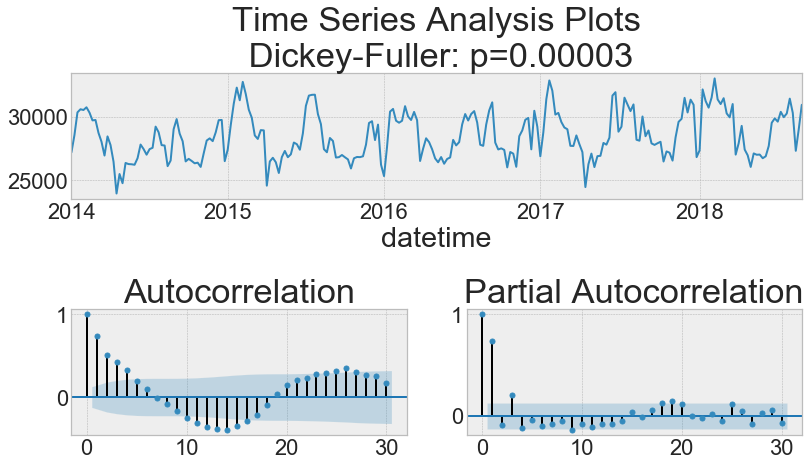

In [20]:
tsplot(weekly_m.value, lags=30)

In [21]:
## Olhando para o p-value acima, notamos que é muito menor que o limiar de 5% (0.05), rejeitando assim a hipótese nula de que a Série
## não é estacionária. Isso nos confirma que a série é, de fato, estacionária

In [22]:
p_value2 = kpss(weekly_m.value, regression='c')[1]
p_value2

0.09203260296313065

In [23]:
## Com o teste KPSS temos o resultado contrário: O p-value acima é maior/muito próximo do limiar de 5% (0.05), aceitando a hipótese nula de que
## a série é estacionária. Isso nos confirma que a série é, de fato, estacionária

# Decomposição da Série

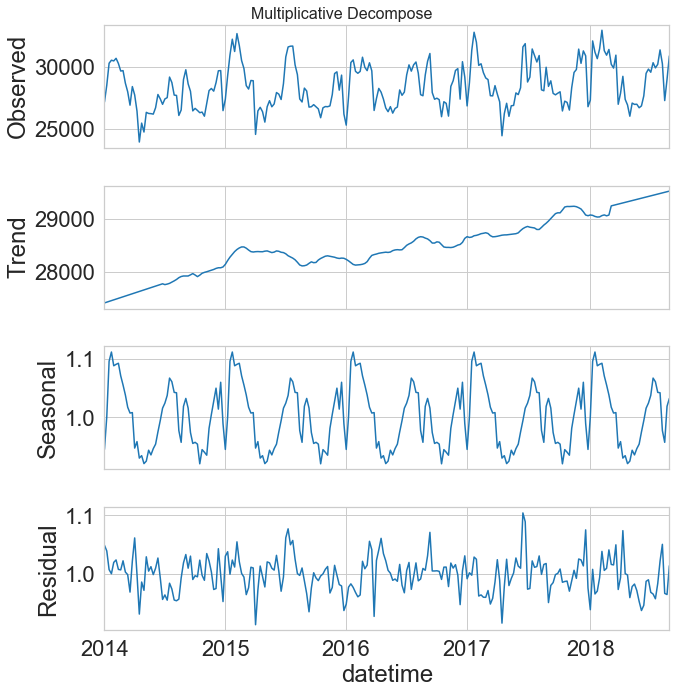

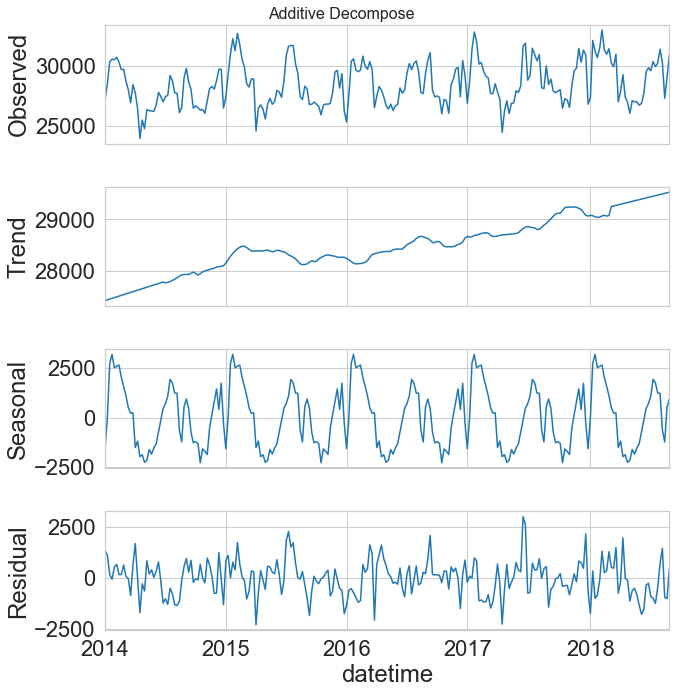

In [24]:
# Decomposição multiplicativa
result_mul = seasonal_decompose(weekly_m['value'], model='multiplicative', extrapolate_trend='freq')

# Decomposição aditiva
result_add = seasonal_decompose(weekly_m['value'], model='additive', extrapolate_trend='freq')

# Plot
plt.rcParams.update({'figure.figsize': (10,10)})
result_mul.plot().suptitle('Multiplicative Decompose', fontsize=16)
result_add.plot().suptitle('Additive Decompose', fontsize=16)
plt.show()

# Transformação Logarítmica e reaplicação dos testes

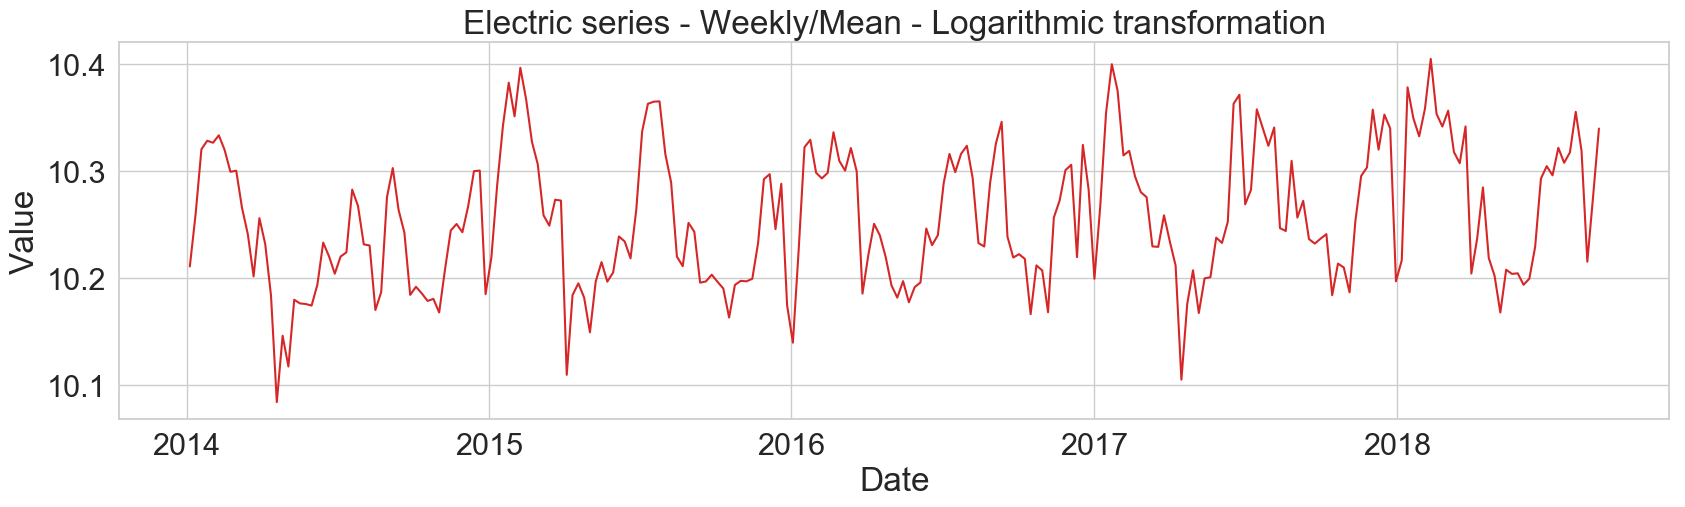

In [25]:
log_data = np.log(weekly_m['value']).to_frame()
plot_df(log_data, x=log_data.index, y=log_data.value, title="Electric series - Weekly/Mean - Logarithmic transformation")

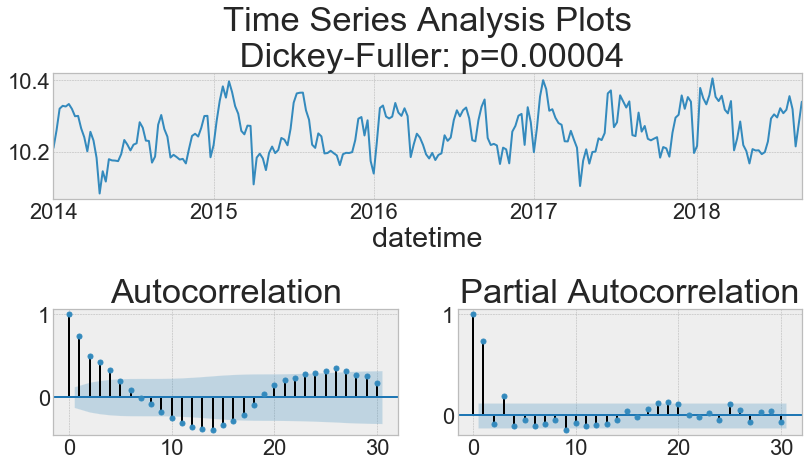

In [26]:
tsplot(log_data.value, lags=30)

In [27]:
p_value2 = kpss(log_data.value, regression='c')[1]
p_value2

0.08996125924078983

## Transformação Retorno Logarítmico

In [34]:
weekly_m_return_log = weekly_m

In [40]:
weekly_m_return_log['return-log'] = np.log(weekly_m_return_log.value) - np.log(weekly_m_return_log.value.shift(1))
weekly_m_return_log.head()

,value,percentage,ano,mes,hora,min,return-log
datetime,,,,,,,
2014-01-05 00:00:00+00:00,27193.678694,0.334442,2014.0,1.000000,11.618557,25.0,NaN
2014-01-12 00:00:00+00:00,28558.553571,0.333475,2014.0,1.000000,11.500000,25.0,0.048972
2014-01-19 00:00:00+00:00,30339.781746,0.333217,2014.0,1.000000,11.500000,25.0,0.060503
2014-01-26 00:00:00+00:00,30582.158730,0.333047,2014.0,1.000000,11.500000,25.0,0.007957
2014-02-02 00:00:00+00:00,30525.325397,0.333133,2014.0,1.285714,11.500000,25.0,-0.001860


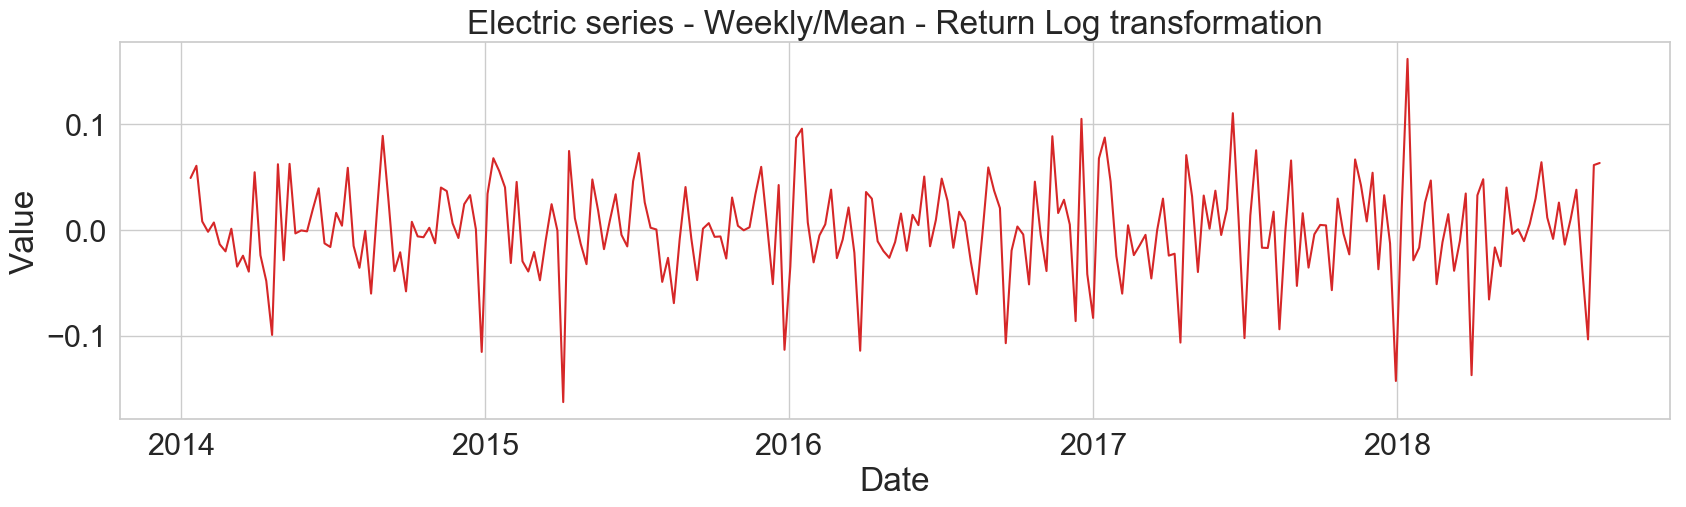

In [43]:
weekly_m_return_log = weekly_m_return_log.dropna()
plot_df(weekly_m_return_log, x=weekly_m_return_log.index, y=weekly_m_return_log['return-log'], title="Electric series - Weekly/Mean - Return Log transformation")

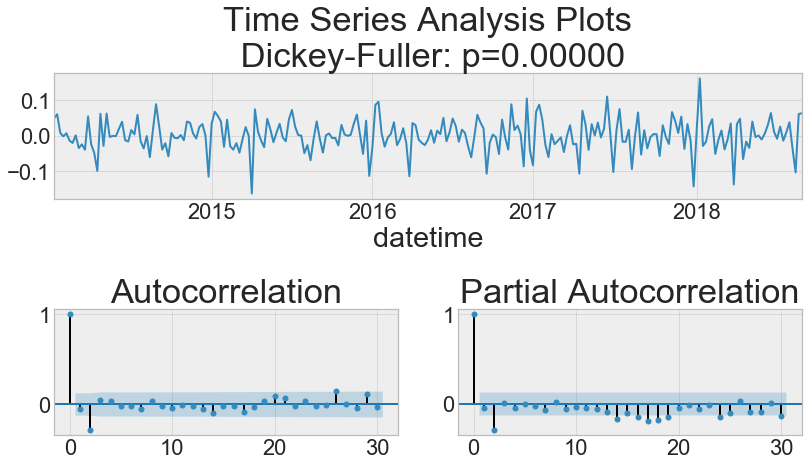

In [44]:
tsplot(weekly_m_return_log['return-log'], lags=30)

In [45]:
p_value2 = kpss(log_data.value, regression='c')[1]
p_value2

0.08996125924078983